In [17]:
import string
import re
from numpy import array, argmax, random, take, delete
import pandas as pd
import nltk
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

UsageError: Line magic function `%` not found.


In [18]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8') # , encoding='utf-8'
    # read all text
    text = file.read()
    file.close()
    return text

In [19]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [20]:
data = read_text("./data/fr.txt")
en_fr = to_lines(data)
en_fr = array(en_fr)

In [36]:
en_fr[10000]

array(['i lit the match', 'jai craqu lallumette'], dtype='<U338')

In [22]:
en_fr = en_fr[:50000,:]

In [23]:
# Remove punctuation
en_fr[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in en_fr[:,0]]
en_fr[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in en_fr[:,1]]

In [24]:
en_fr[1]

array(['Run', 'Cours'], dtype='<U338')

In [25]:
# convert to lowercase
for i in range(len(en_fr)):
    en_fr[i,0] = en_fr[i,0].lower()
    
    en_fr[i,1] = en_fr[i,1].lower()

In [26]:
en_fr[:,1]

array(['va ', 'cours', 'courez', ..., 'ils vont au travail  pied',
       'ils montrent dans le train', 'elles montrent dans le train'],
      dtype='<U338')

In [27]:
# empty lists
en_l = []
fr_l = []

# populate the lists with sentence lengths
for i in en_fr[:,0]:
    en_l.append(len(i.split()))

for i in en_fr[:,1]:
    fr_l.append(len(i.split()))

In [28]:
length_df = pd.DataFrame({'en':en_l, 'fr':fr_l})

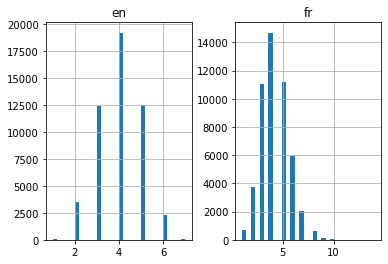

In [29]:
length_df.hist(bins = 30)
plt.show()

In [30]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [31]:
# prepare english tokenizer
en_tokenizer = tokenization(en_fr[:, 0])
en_vocab_size = len(en_tokenizer.word_index) + 1

en_length = 8
print('English Vocabulary Size: %d' % en_vocab_size)

English Vocabulary Size: 6081


In [32]:
# prepare French tokenizer
fr_tokenizer = tokenization(en_fr[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

fr_length = 8
print('French Vocabulary Size: %d' % fr_vocab_size)

French Vocabulary Size: 12448


In [33]:
import pickle

# saving
with open('./vocabulary/fr_tokenizer.pickle', 'wb') as handle:
    pickle.dump(fr_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [34]:
# saving
with open('./vocabulary/en_tokenizer.pickle', 'wb') as handle:
    pickle.dump(en_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(en_fr, test_size=0.2, random_state = 12)

In [68]:
# prepare training data
trainX = encode_sequences(en_tokenizer, en_length, train[:, 0])
trainY = encode_sequences(fr_tokenizer, fr_length, train[:, 1])

In [69]:
# prepare validation data
testX = encode_sequences(en_tokenizer, en_length, test[:, 0])
testY = encode_sequences(fr_tokenizer, fr_length, test[:, 1])

In [70]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [71]:
model = build_model(en_vocab_size, fr_vocab_size, en_length, fr_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [72]:
filename = 'model.h1.en_fr'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 14s 143ms/step - loss: 5.1417 - accuracy: 0.4465 - val_loss: 3.6339 - val_accuracy: 0.4975

Epoch 00001: val_loss improved from inf to 3.63393, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 2/30
63/63 [==============================] - 10s 164ms/step - loss: 3.5489 - accuracy: 0.5057 - val_loss: 3.5067 - val_accuracy: 0.5139

Epoch 00002: val_loss improved from 3.63393 to 3.50669, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 3/30
63/63 [==============================] - 10s 164ms/step - loss: 3.3760 - accuracy: 0.5192 - val_loss: 3.4124 - val_accuracy: 0.5252

Epoch 00003: val_loss improved from 3.50669 to 3.41242, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 4/30
63/63 [==============================] - 11s 166ms/step - loss: 3.2110 - accuracy: 0.5321 - val_loss: 3.3000 - val_accuracy: 0.5349

Epoch 00004: val_loss improved from 3.41242 to 3.30000, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 5/30
63/63 [==============================] - 10s 158ms/step - loss: 3.0717 - accuracy: 0.5424 - val_loss: 3.1329 - val_accuracy: 0.5494

Epoch 00005: val_loss improved from 3.30000 to 3.13291, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 6/30
63/63 [==============================] - 10s 157ms/step - loss: 2.9073 - accuracy: 0.5601 - val_loss: 3.0260 - val_accuracy: 0.5685

Epoch 00006: val_loss improved from 3.13291 to 3.02602, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 7/30
63/63 [==============================] - 10s 159ms/step - loss: 2.7797 - accuracy: 0.5724 - val_loss: 2.9299 - val_accuracy: 0.5800

Epoch 00007: val_loss improved from 3.02602 to 2.92992, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 8/30
63/63 [==============================] - 9s 140ms/step - loss: 2.6547 - accuracy: 0.5851 - val_loss: 2.8403 - val_accuracy: 0.5875

Epoch 00008: val_loss improved from 2.92992 to 2.84030, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 9/30
63/63 [==============================] - 9s 141ms/step - loss: 2.5458 - accuracy: 0.5950 - val_loss: 2.7943 - val_accuracy: 0.5922

Epoch 00009: val_loss improved from 2.84030 to 2.79431, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 10/30
63/63 [==============================] - 9s 139ms/step - loss: 2.4481 - accuracy: 0.6015 - val_loss: 2.7294 - val_accuracy: 0.5989

Epoch 00010: val_loss improved from 2.79431 to 2.72941, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 11/30
63/63 [==============================] - 9s 141ms/step - loss: 2.3647 - accuracy: 0.6069 - val_loss: 2.6628 - val_accuracy: 0.6050

Epoch 00011: val_loss improved from 2.72941 to 2.66285, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 12/30
63/63 [==============================] - 9s 138ms/step - loss: 2.2699 - accuracy: 0.6136 - val_loss: 2.6356 - val_accuracy: 0.6054

Epoch 00012: val_loss improved from 2.66285 to 2.63557, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 13/30
63/63 [==============================] - 9s 139ms/step - loss: 2.1810 - accuracy: 0.6208 - val_loss: 2.5902 - val_accuracy: 0.6123

Epoch 00013: val_loss improved from 2.63557 to 2.59022, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 14/30
63/63 [==============================] - 9s 142ms/step - loss: 2.0978 - accuracy: 0.6258 - val_loss: 2.5221 - val_accuracy: 0.6186

Epoch 00014: val_loss improved from 2.59022 to 2.52215, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 15/30
63/63 [==============================] - 9s 141ms/step - loss: 2.0176 - accuracy: 0.6311 - val_loss: 2.4706 - val_accuracy: 0.6239

Epoch 00015: val_loss improved from 2.52215 to 2.47057, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 16/30
63/63 [==============================] - 9s 141ms/step - loss: 1.9337 - accuracy: 0.6405 - val_loss: 2.4278 - val_accuracy: 0.6275

Epoch 00016: val_loss improved from 2.47057 to 2.42785, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 17/30
63/63 [==============================] - 9s 141ms/step - loss: 1.8555 - accuracy: 0.6473 - val_loss: 2.4093 - val_accuracy: 0.6300

Epoch 00017: val_loss improved from 2.42785 to 2.40929, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 18/30
63/63 [==============================] - 9s 140ms/step - loss: 1.7772 - accuracy: 0.6548 - val_loss: 2.3575 - val_accuracy: 0.6352

Epoch 00018: val_loss improved from 2.40929 to 2.35755, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 19/30
63/63 [==============================] - 9s 140ms/step - loss: 1.7061 - accuracy: 0.6615 - val_loss: 2.3408 - val_accuracy: 0.6359

Epoch 00019: val_loss improved from 2.35755 to 2.34081, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 20/30
63/63 [==============================] - 9s 142ms/step - loss: 1.6479 - accuracy: 0.6673 - val_loss: 2.2878 - val_accuracy: 0.6409

Epoch 00020: val_loss improved from 2.34081 to 2.28779, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 21/30
63/63 [==============================] - 9s 139ms/step - loss: 1.5594 - accuracy: 0.6783 - val_loss: 2.2512 - val_accuracy: 0.6448

Epoch 00021: val_loss improved from 2.28779 to 2.25115, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 22/30
63/63 [==============================] - 9s 140ms/step - loss: 1.4936 - accuracy: 0.6850 - val_loss: 2.2263 - val_accuracy: 0.6473

Epoch 00022: val_loss improved from 2.25115 to 2.22633, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 23/30
63/63 [==============================] - 9s 143ms/step - loss: 1.4335 - accuracy: 0.6919 - val_loss: 2.2215 - val_accuracy: 0.6496

Epoch 00023: val_loss improved from 2.22633 to 2.22150, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 24/30
63/63 [==============================] - 9s 143ms/step - loss: 1.3694 - accuracy: 0.7005 - val_loss: 2.1758 - val_accuracy: 0.6542

Epoch 00024: val_loss improved from 2.22150 to 2.17583, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 25/30
63/63 [==============================] - 9s 141ms/step - loss: 1.3055 - accuracy: 0.7088 - val_loss: 2.1512 - val_accuracy: 0.6580

Epoch 00025: val_loss improved from 2.17583 to 2.15115, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 26/30
63/63 [==============================] - 9s 139ms/step - loss: 1.2452 - accuracy: 0.7171 - val_loss: 2.1384 - val_accuracy: 0.6560

Epoch 00026: val_loss improved from 2.15115 to 2.13837, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 27/30
63/63 [==============================] - 9s 143ms/step - loss: 1.1887 - accuracy: 0.7260 - val_loss: 2.1106 - val_accuracy: 0.6634

Epoch 00027: val_loss improved from 2.13837 to 2.11057, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 28/30
63/63 [==============================] - 9s 142ms/step - loss: 1.1357 - accuracy: 0.7335 - val_loss: 2.1041 - val_accuracy: 0.6646

Epoch 00028: val_loss improved from 2.11057 to 2.10413, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 29/30
63/63 [==============================] - 9s 141ms/step - loss: 1.0816 - accuracy: 0.7426 - val_loss: 2.0815 - val_accuracy: 0.6649

Epoch 00029: val_loss improved from 2.10413 to 2.08150, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


Epoch 30/30
63/63 [==============================] - 9s 141ms/step - loss: 1.0255 - accuracy: 0.7535 - val_loss: 2.0641 - val_accuracy: 0.6685

Epoch 00030: val_loss improved from 2.08150 to 2.06414, saving model to model.h1.en_fr


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


INFO:tensorflow:Assets written to: model.h1.en_fr/assets


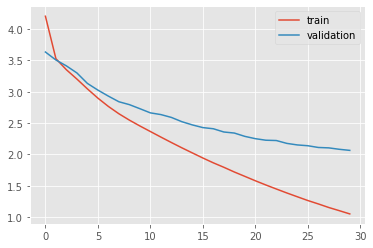

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [74]:
model = load_model('model.h1.en_fr')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [75]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [76]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], fr_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], fr_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [77]:
loss, accuracy = model.evaluate(trainX, trainY, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(testX, testY, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7481
Testing Accuracy:  0.6710


In [78]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

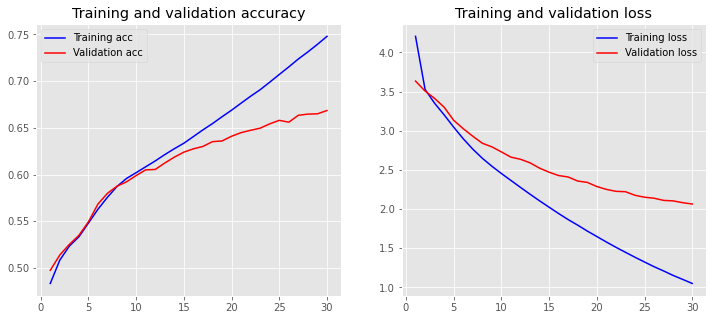

In [79]:
plot_history(history)

In [88]:
pred_df = pd.DataFrame({'english': test[:,0],'actual' : test[:,1], 'predicted' : preds_text})

In [89]:
pd.set_option('display.max_colwidth', 200)

In [90]:
pred_df.head(15)

,english,actual,predicted
0,you seem happy today,tu as lair heureux aujourdhui,vous as lair aujourdhui
1,i like tea,jaime le th,jaime le musique
2,im firing you,je te vire,je vous vire
3,i am a tourist,je suis touriste,je suis un touriste
4,she showed me her room,elle ma montr sa chambre,elle lui donn une vie
5,do you like this music,aimestu cette musique,aimezvous aimez le musique
6,you cant make us stop,tu ne peux pas nous faire nous arrter,vous ne pouvez pas faire
7,i had to do this today,je devais le faire aujourdhui,il d fallu faire aujourdhui
8,id like to stand,jaimerais me prsenter,jaimerais tre debout
9,i was thrown off guard,jai t pris par surprise,jtais t la jai


In [94]:
pred_df.tail(15)

,english,actual,predicted
9985,we swam in the sea,nous nagemes dans la mer,nous avons dans la
9986,were all hungry,nous avons tous faim,nous avons tous faim
9987,thats very serious,a cest trs srieux,cest vraiment vrai
9988,im a natural blonde,je suis dun blond naturel,je suis un peu
9989,im not in trouble,je nai pas de problme,je ne pas de
9990,breakfast is served,le petitdjeuner est servi,le djeuner est
9991,he was imprisoned,il fut emprisonn,il a t emprisonn
9992,i eat alone,je mange seule,je me seul
9993,i have terrible pains,jai daffreuses douleurs,je dteste suis araignes
9994,he was deaf too,il tait aussi sourd,il tait trs


In [45]:
test

array([['you seem happy today', 'tu as lair heureux aujourdhui'],
       ['i like tea', 'jaime le th'],
       ['im firing you', 'je te vire'],
       ...,
       ['he did not listen', 'il ncouta pas'],
       ['call me when its done', 'appelezmoi quand cest fait'],
       ['you were so strong', 'vous tiez si fortes']], dtype='<U338')

In [44]:
train

array([['do not open your book', 'nouvre pas ton livre'],
       ['i really need a drink', 'jai vraiment besoin dun verre'],
       ['do you want to see more', 'voulezvous en voir davantage '],
       ...,
       ['why did i do this', 'pourquoilaijefait'],
       ['that house is haunted', 'cette maison est hante'],
       ['just keep moving', 'continuons  avancer ']], dtype='<U338')

In [91]:
test[1]

array(['i like tea', 'jaime le th'], dtype='<U338')

In [49]:
testX[1]

array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)